In [1]:
import torch
import clip
from PIL import Image
import numpy as np
import os
import pickle
from tqdm import tqdm

# ------------------------------
# 1. Load CLIP
# ------------------------------
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# ------------------------------
# 2. Define categories
# ------------------------------
categories = [
    "a photo taken indoors, inside a building or a car",
    "a photo primarily of a terraced house",
    "a photo primarily of a detached or semi detached house",
    "a photo primarily of a road",
    "a photo of a shop",
    "a photo dominated by the outside of a car",
    "a photo of an industrial building",
    "a photo of wasteland, empty space",
    "a photo of nice green space, e.g. parks, gardens, nice trees and flowers"
]

text_tokens = clip.tokenize(categories).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)  # normalize once


# ------------------------------
# 3. CLIP embedding + scoring
# ------------------------------
def embed_and_score_clip(img_path):
    """Return CLIP embedding (512d) + category similarity scores."""
    img = Image.open(img_path).convert("RGB")
    image_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        image_feat = model.encode_image(image_tensor)
        image_feat /= image_feat.norm(dim=-1, keepdim=True)  # normalize for cosine sim

        # similarities → shape (1, num_categories)
        sims = (image_feat @ text_features.T).softmax(dim=-1)

    return (
        image_feat.cpu().numpy()[0],      # 512-dim embedding
        sims.cpu().numpy()[0]             # category probs (len 9)
    )


# ------------------------------
# 4. Dummy fields for compatibility
# ------------------------------
def empty_attention_stats():
    return {"mean": None, "std": None, "entropy": None, "max_y": None, "max_x": None}


# ------------------------------
# 5. Embed + score all images
# ------------------------------
for rec in tqdm(point_records, desc="Embedding points", unit="point"):

    rec["embeddings"] = []
    rec["category_scores"] = []      # <—— NEW
    rec["attn_stats"] = []           # empty placeholders
    rec["heatmap_paths"] = []        # always None

    for img_path in rec["image_files"][:100]:
        img_path = (
            img_path.replace("airbnb-manchester/", "embeddings/")
                    .replace("../", "../../")
        )

        if not os.path.exists(img_path):
            continue

        try:
            embedding, scores = embed_and_score_clip(img_path)

            rec["embeddings"].append(embedding)
            rec["category_scores"].append(scores)
            rec["attn_stats"].append(empty_attention_stats())
            rec["heatmap_paths"].append(None)

        except Exception as e:
            tqdm.write(f"⚠️ Error processing {img_path}: {e}")


# ------------------------------
# 6. Save cache
# ------------------------------
output_file = (
    data_dir + "sample_points_cache/points_data_cache_with_CLIP_embeddings_and_scores.pkl"
)

with open(output_file, "wb") as f:
    pickle.dump(point_records, f)

print(f"\n💾 Saved embeddings + category scores for {len(point_records)} points.")


NameError: name 'point_records' is not defined

In [1]:
import pickle
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString
import random 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_ind
import hdbscan
from itertools import combinations
import umap
import seaborn as sns
from tqdm import tqdm
import torch
import clip
from sklearn.ensemble import IsolationForest

from functions import *

In [2]:
data_dir = os.path.join("../../data/embeddings/")
lsoas_file = os.path.join("../../data/SpatialData/", "LSOAs_2021", "LSOA_2021_EW_BSC_V4.shp")

## Embeddings 
### Get embeddings (four per location)

In [3]:
points_data_cache = data_dir + "sample_points_cache/points_data_cache_with_embeddings_and_attn_stats_new.pkl"
with open(points_data_cache, "rb") as f:
    point_records = pickle.load(f)

### Join image embeddings points to gentrification LSOAs

In [4]:
point_coords = [Point(rec['longitude'], rec['latitude']) for rec in point_records]
points_labels_gdf = gpd.GeoDataFrame(point_records, geometry=point_coords, crs="EPSG:4326")

### Expand so there is one row per each image

In [5]:
expanded_rows = []

for _, row in points_labels_gdf.iterrows():
    embeddings = row['embeddings']      # list of 4 embeddings
    images = row['image_files']        # list of 4 image paths

    # Skip if lengths don't match
    if len(embeddings) != len(images):
        print(f"Skipping row {row.name}: {len(embeddings)} embeddings, {len(images)} images")
        continue

    for emb, img in zip(embeddings, images):
        new_row = row.to_dict()        # copy all other columns
        new_row['embeddings'] = emb     # single embedding
        new_row['image_files'] = img    # single image
        expanded_rows.append(new_row)

# Create new DataFrame
expanded_gdf = pd.DataFrame(expanded_rows)
print(f"Original rows: {len(points_labels_gdf)}, Expanded rows: {len(expanded_gdf)}")
expanded_gdf = pd.DataFrame(expanded_rows)


Skipping row 9158: 3 embeddings, 4 images
Skipping row 12091: 3 embeddings, 4 images
Skipping row 18664: 3 embeddings, 4 images
Original rows: 18897, Expanded rows: 75576


In [6]:
all_embeddings = np.stack(expanded_gdf['embeddings'].values)

### Classify

In [7]:
# --- Plot function ---
def plot_images_with_scores(image_paths, category_probs, category_names, n_cols=3, sort_by=None):
    """
    Plots images in a grid with category probabilities above each image.
    """
    if sort_by is not None:
        sort_idx = np.argsort(category_probs[:, category_names.index(sort_by)])[::-1]
        image_paths = [image_paths[i] for i in sort_idx]
        category_probs = category_probs[sort_idx]
    
    n_images = len(image_paths)
    n_rows = math.ceil(n_images / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
    axs = axs.flatten()
    
    for i in range(n_images):
        try:
            img = Image.open(image_paths[i])
            axs[i].imshow(img)
        except:
            axs[i].axis('off')
            continue
        
        scores_text = "\n".join([
            f"{name}: {category_probs[i, idx]:.2f}" 
            for idx, name in enumerate(category_names)
        ])
        axs[i].set_title(scores_text, fontsize=9)
        axs[i].axis('off')
    
    # Turn off unused axes
    for j in range(n_images, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()


In [8]:
import torch
import clip
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math

# --- Load CLIP ---
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# --- Define categories ---
categories = [
    "a photo taken indoors, inside a building or a car ",
     "a photo primarily of a terraced house",
     "a photo primarily of a detached or semi detached house",
    "a photo primarily of a road",
    "a photo of a shop",
    "a photo dominated by the outside of a car",
    "a photo of an industrial building",
    "a photo of wasteland, empty space",
    "a photo of nice green space, e.g. parks, gardens, nice trees and flowers"
    
]

category_names = ["indoor", "terraced house","semi-detached house", "road", "shop", "car", "industrial", "wasteland", "greenery"]  # For plotting

# --- Tokenize once ---
text_tokens = clip.tokenize(categories).to(device)

# --- Compute category probabilities ---
image_paths_adj = []
category_probs = []

for img_path in tqdm(expanded_gdf['image_files'][:1000], desc="Processing images"):
    adj_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../")
    try:
        image = preprocess(Image.open(adj_path)).unsqueeze(0).to(device)
    except:
        continue
    
    with torch.no_grad():
        img_feat = model.encode_image(image)
        txt_feat = model.encode_text(text_tokens)
        sims = (img_feat @ txt_feat.T).softmax(dim=-1)
        category_probs.append(sims.cpu().numpy()[0])
        image_paths_adj.append(adj_path)

category_probs = np.array(category_probs)

Processing images: 100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:01<00:00,  2.77it/s]


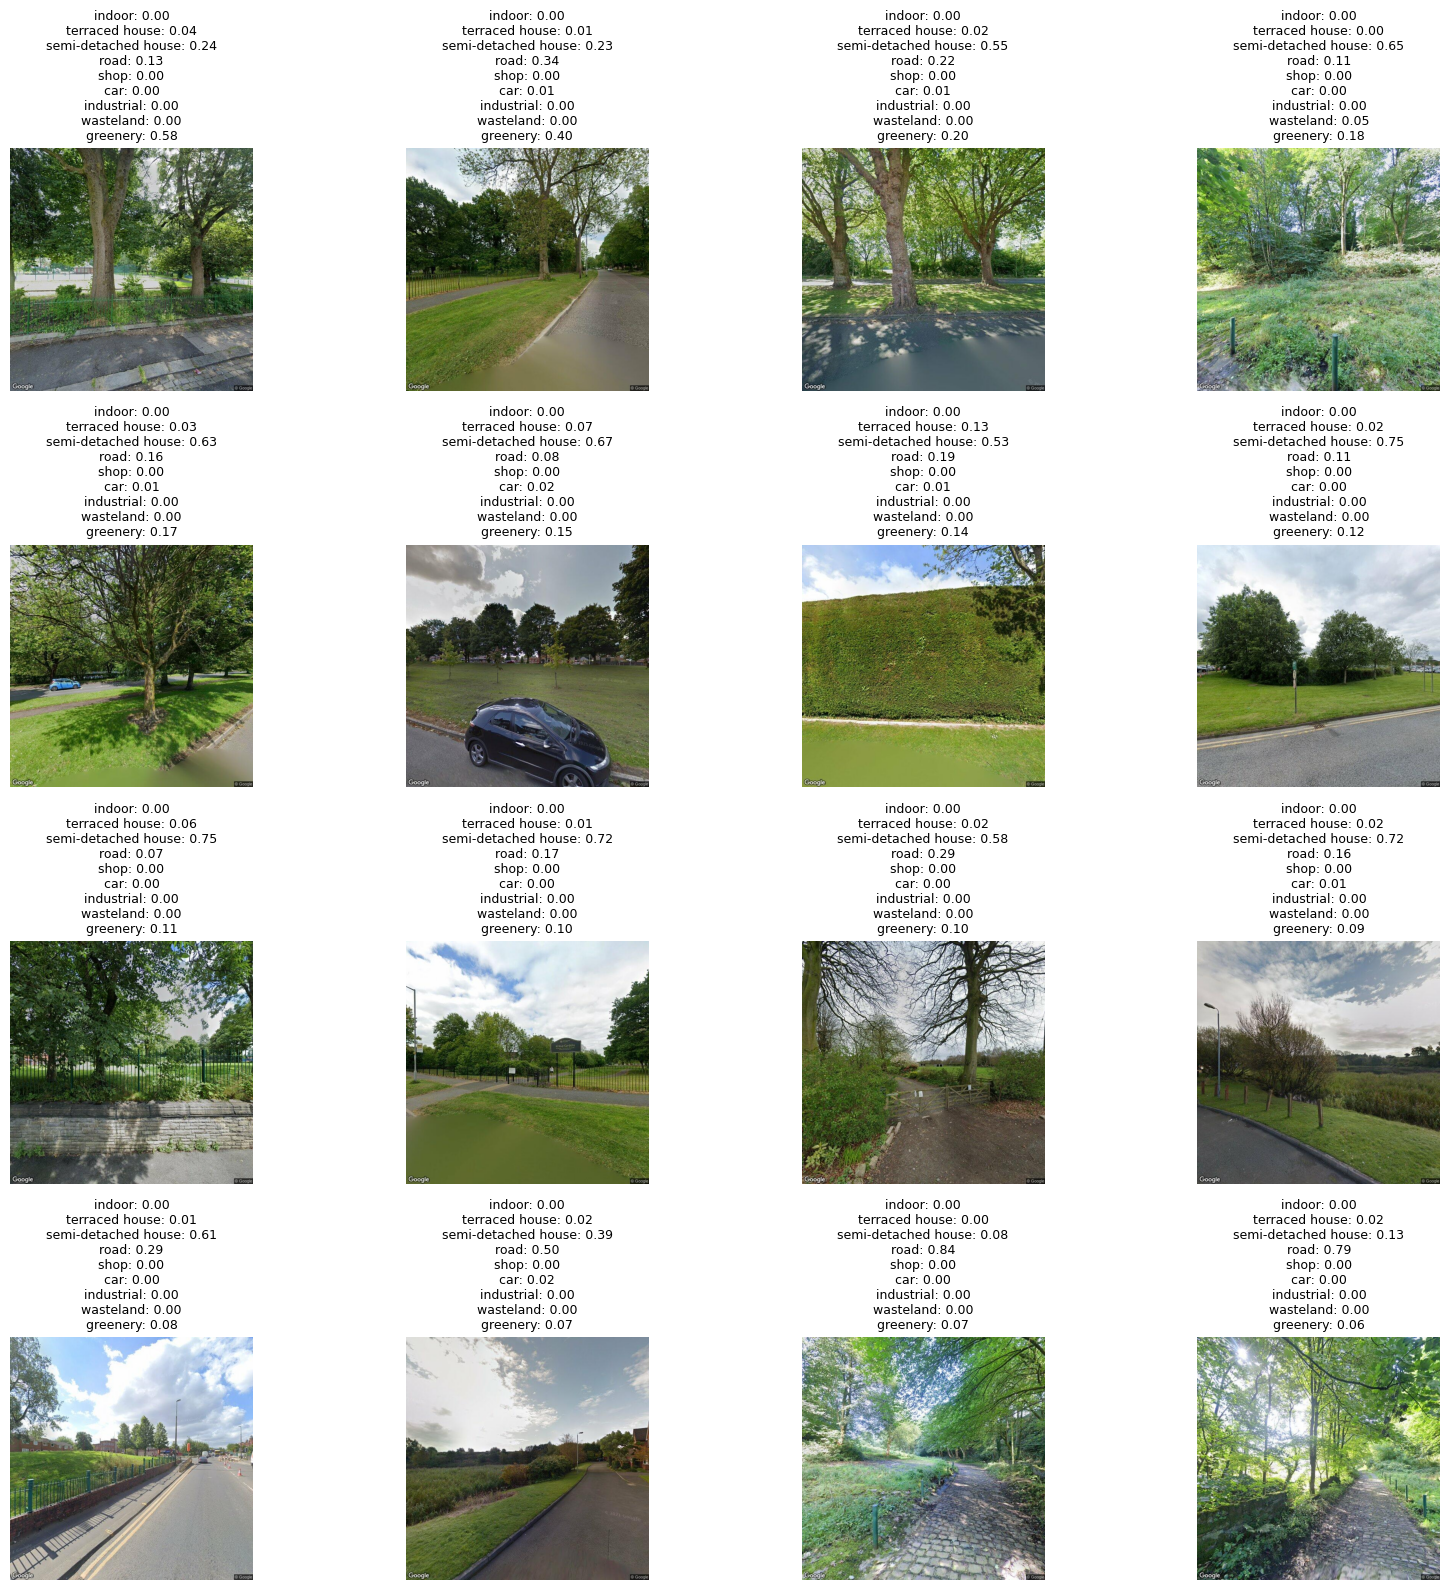

In [17]:
# --- Plot function ---
def plot_images_with_scores(image_paths, category_probs, category_names, n_images, n_cols=3, sort_by=None):
    """
    Plots images in a grid with category probabilities above each image.
    """
    if sort_by is not None:
        sort_idx = np.argsort(category_probs[:, category_names.index(sort_by)])[::-1]
        image_paths = [image_paths[i] for i in sort_idx]
        category_probs = category_probs[sort_idx]
    
    #n_images = len(image_paths)
    n_rows = math.ceil(n_images / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
    axs = axs.flatten()
    
    for i in range(n_images):
        try:
            img = Image.open(image_paths[i])
            axs[i].imshow(img)
        except:
            axs[i].axis('off')
            continue
        
        scores_text = "\n".join([
            f"{name}: {category_probs[i, idx]:.2f}" 
            for idx, name in enumerate(category_names)
        ])
        axs[i].set_title(scores_text, fontsize=9)
        axs[i].axis('off')
    
    # Turn off unused axes
    for j in range(n_images, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_images_with_scores(image_paths_adj, category_probs, category_names, n_images=16, n_cols=4, sort_by="greenery")

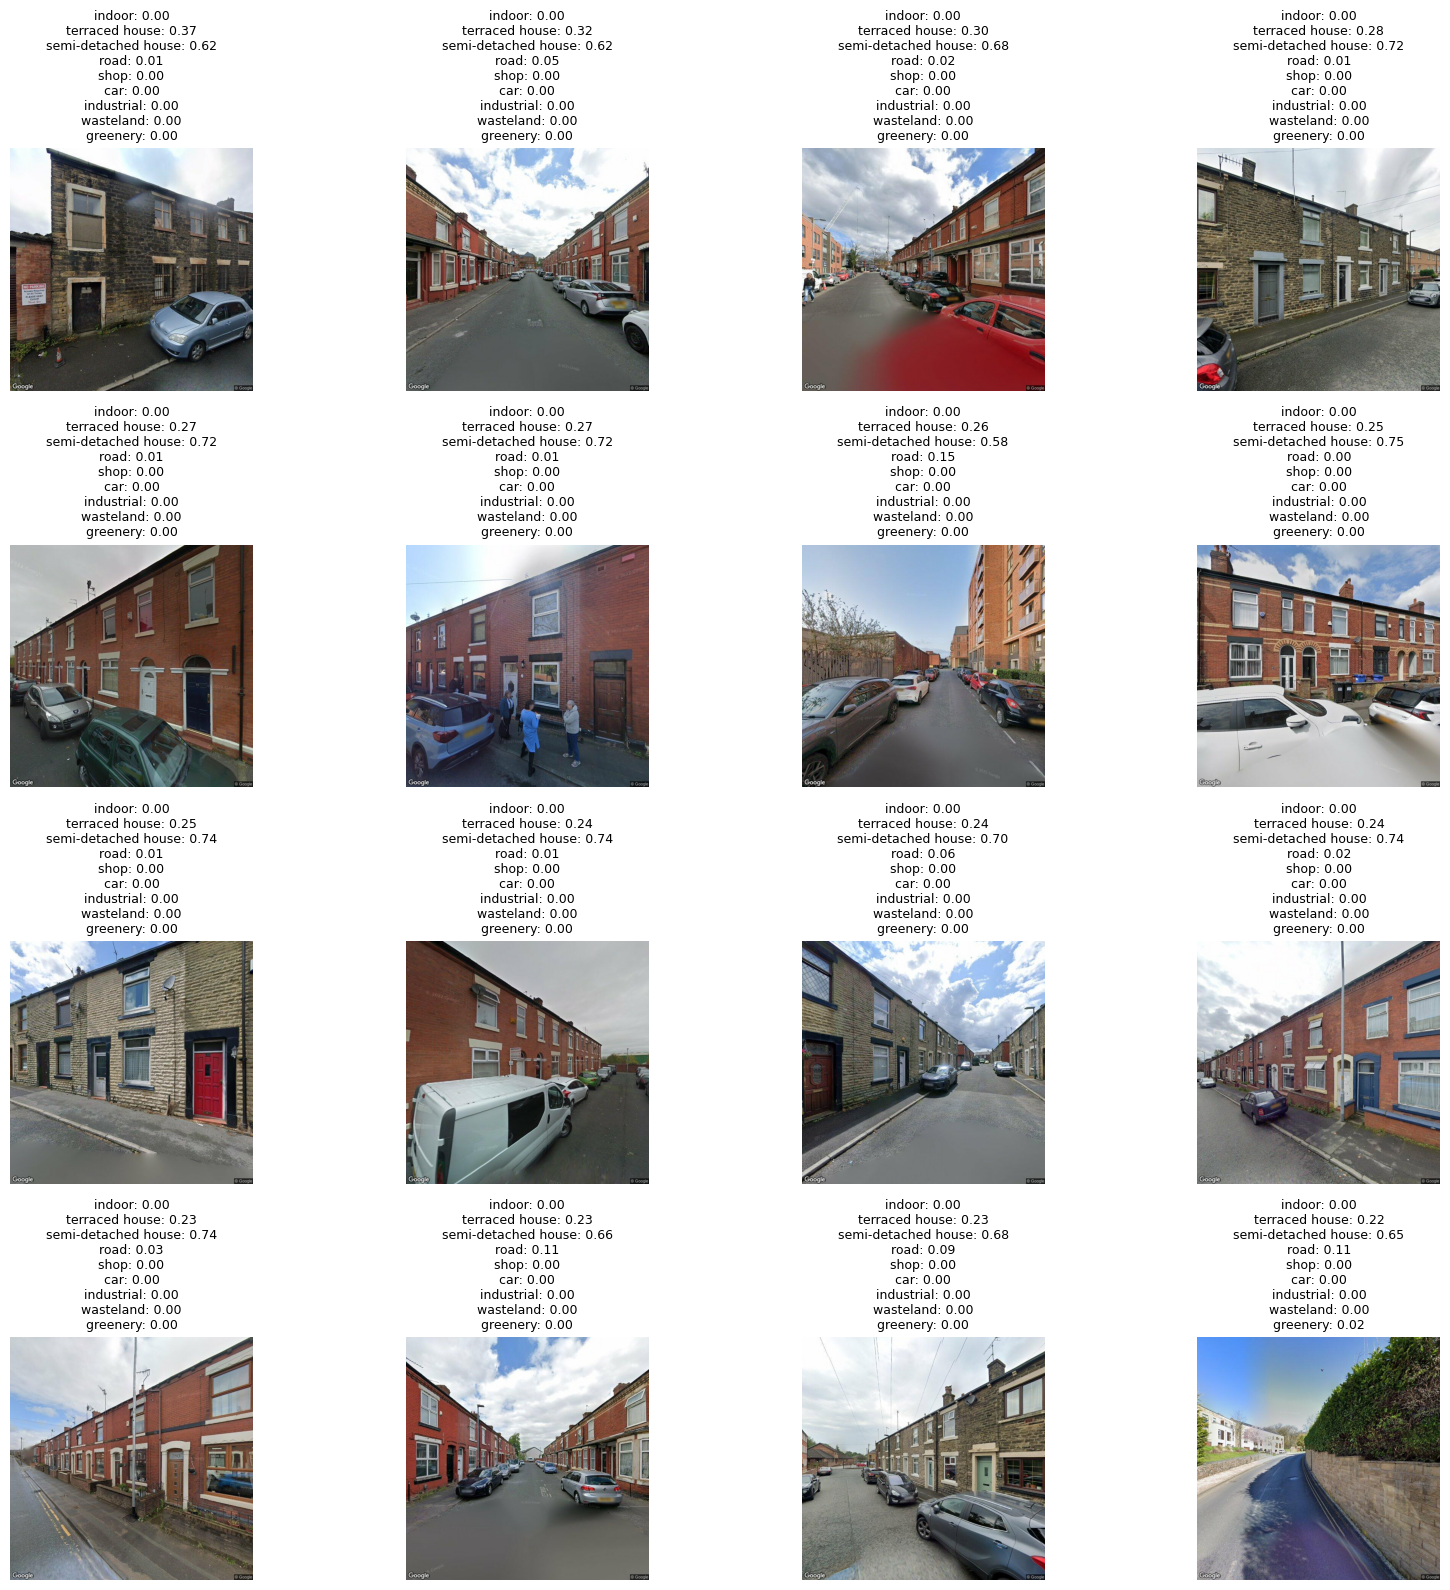

In [14]:
# --- Plot function ---
def plot_images_with_scores(image_paths, category_probs, category_names, n_images, n_cols=3, sort_by=None):
    """
    Plots images in a grid with category probabilities above each image.
    """
    if sort_by is not None:
        sort_idx = np.argsort(category_probs[:, category_names.index(sort_by)])[::-1]
        image_paths = [image_paths[i] for i in sort_idx]
        category_probs = category_probs[sort_idx]
    
    #n_images = len(image_paths)
    n_rows = math.ceil(n_images / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
    axs = axs.flatten()
    
    for i in range(n_images):
        try:
            img = Image.open(image_paths[i])
            axs[i].imshow(img)
        except:
            axs[i].axis('off')
            continue
        
        scores_text = "\n".join([
            f"{name}: {category_probs[i, idx]:.2f}" 
            for idx, name in enumerate(category_names)
        ])
        axs[i].set_title(scores_text, fontsize=9)
        axs[i].axis('off')
    
    # Turn off unused axes
    for j in range(n_images, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_images_with_scores(image_paths_adj, category_probs, category_names, n_images=16, n_cols=4, sort_by="terraced house")